In [1]:
import torch
from datasets import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 64
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

In [2]:
import pytorch_lightning as pl
from models import VAE

class VanillaVAE(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.VAE = VAE()
    
    def forward(self, x, x_cond):
        return self.VAE(x)
    
    def training_step(self, batch, batch_idx):
        x, x_cond, y = batch
        output, z_mean, z_log_var, z = self.VAE(x)
        recon_loss, kl_loss, loss = self.VAE.loss(x, output, z_mean, z_log_var)
        self.log('train_loss', loss)
        self.log('train_recon_loss', recon_loss)
        self.log('train_kl_loss', kl_loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, x_cond, y = batch
        output, z_mean, z_log_var, z = self.VAE(x)
        recon_loss, kl_loss, loss = self.VAE.loss(x, output, z_mean, z_log_var)
        self.log('val_loss', loss)
        self.log('val_recon_loss', recon_loss)
        self.log('val_kl_loss', kl_loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, x_cond, y = batch
        output, z_mean, z_log_var, z = self.VAE(x)
        recon_loss, kl_loss, loss = self.VAE.loss(x, output, z_mean, z_log_var)
        self.log('test_loss', loss)
        self.log('test_recon_loss', recon_loss)
        self.log('test_kl_loss', kl_loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [3]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='vae-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

scvae = VanillaVAE()
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=40, enable_progress_bar=True, callbacks=[checkpoint_callback])
trainer.fit(scvae, train_loader, val_loader)
#save
trainer.save_checkpoint('checkpoints/vae_40.ckpt')

/Home/siv34/edzak2974/.conda/envs/pytorch_birget/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_birget/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_birget/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_birget/lib ...
  rank_zero_warn(
You are using a CUDA device ('A100-SXM

Sanity Checking: 0it [00:00, ?it/s]

TypeError: recon_loss() missing 1 required positional argument: 'outputs'

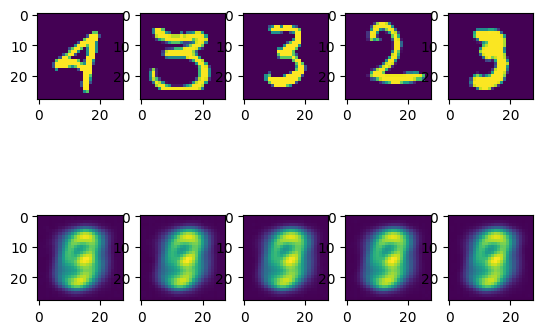

In [3]:
#load
scvae = VanillaVAE.load_from_checkpoint('checkpoints/vae_40.ckpt')
scvae.eval()
from plotting import plot_samples_with_reconstruction
# plot some samples and their reconstruction
plot_samples_with_reconstruction(scvae, next(iter(test_loader)))